# Machine Learning using Logistic Regression

Classifier model that estimates an applicant’s probability of admission based the scores from those two exams.

In [1]:
import pandas as pd
import numpy as np
# import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('ex2data1.txt', names = ['score1', 'score2', 'admitted'])
data = data.astype('float128')
print('Profiling Data')
print(data.info())
print(data.head())

# profile = pandas_profiling.ProfileReport(df)
# profile.to_file(outputfile="output.html")

Profiling Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
score1      100 non-null float128
score2      100 non-null float128
admitted    100 non-null float128
dtypes: float128(3)
memory usage: 4.8 KB
None
      score1     score2  admitted
0  34.623660  78.024693       0.0
1  30.286711  43.894998       0.0
2  35.847409  72.902198       0.0
3  60.182599  86.308552       1.0
4  79.032736  75.344376       1.0


In [3]:
x = np.array(data[['score1', 'score2']]) # training set
y = np.array(data['admitted']) # labels
[m, n] = np.shape(x)

## ==================== Part 1: Plotting ====================

Plotting data with "x" indicating (y = 1) examples and "o" indicating (y = 0) examples.


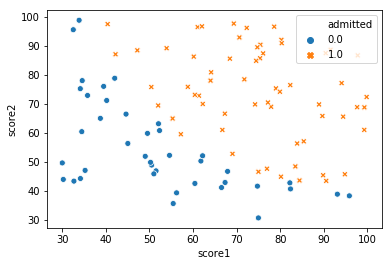

In [4]:
print('Plotting data with "x" indicating (y = 1) examples and "o" indicating (y = 0) examples.')
sns.scatterplot('score1', 'score2', hue='admitted', style='admitted', data=data)

## =========== Part 2: Mapping Features ============

One way to fit the data better is to create more features from each data point. We will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.

While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. To void that we will implement regularized logistic regression to fit the data and combat the overfitting problem.

In [5]:
"""
Normalizes the features in X 
returns a normalized version of X where the mean value of each feature is 0 and the standard deviation is 1.
This is often a good preprocessing step to do when working with learning algorithms.

First, for each feature dimension, compute the mean of the feature and subtract it from the dataset,
storing the mean value in mu. Next, compute the  standard deviation of each feature and divide
each feature by it's standard deviation, storing the standard deviation in sigma.
"""
def featureNormalize(X):
    X_norm = np.zeros(np.shape(X))
    qty_features = np.shape(X)[1]
    mu = np.zeros(qty_features)
    sigma = np.zeros(qty_features)
    
    for i in range(qty_features):
        mu[i] = np.mean(X[:,i])
        X_norm[:,i] = X[:,i] - mu[i]
        
        # by default np.std calculate the population std, here we want sample std (as done in Octave)
        sigma[i] = np.std(X_norm[:,i], ddof=1) # default: ddof=0 (N - 0) will predict 293092.21273075533
        X_norm[:,i] = X_norm[:,i] / sigma[i]
    return X_norm, mu, sigma

In [6]:
# Tessting Feature Normalization
X_ = np.array([
    [2104, 3],
    [1600, 3],
    [2400, 3],
    [1416, 2],
    [3000, 4]
])
X_n, mu_, sigma_ = featureNormalize(X_)
print("X Norm", X_n)
print("mu", mu_) # [2104.    3.]
print("sigma", sigma_) # [635.96226303   0.70710678]

X Norm [[ 0.          0.        ]
 [-0.79249985  0.        ]
 [ 0.46543642  0.        ]
 [-1.0818252  -1.41421356]
 [ 1.40888863  1.41421356]]
mu [2104.    3.]
sigma [635.96226303   0.70710678]


In [7]:
# Scale features and set them to zero mean
print('Normalizing Features ...\n')
# We normalize to avoid log(0) because our sigmoid will return small values
X, mu, sigma = featureNormalize(x)

print('Normalized data')
X[:5]

Normalizing Features ...

Normalized data


array([[-1.59421626,  0.63514139],
       [-1.81710142, -1.20148852],
       [-1.53132516,  0.35948329],
       [-0.28068724,  1.08092281],
       [ 0.68806193,  0.49090485]])

In [8]:
# Add a column of ones to X to facilitate the manipulation
X = np.column_stack((np.ones(m), X))
X[:5]

array([[ 1.        , -1.59421626,  0.63514139],
       [ 1.        , -1.81710142, -1.20148852],
       [ 1.        , -1.53132516,  0.35948329],
       [ 1.        , -0.28068724,  1.08092281],
       [ 1.        ,  0.68806193,  0.49090485]])

## ============ Part 3: Compute Cost and Gradient ============

### Activation Function
We will use the sigmoid function as our activation function.

$g(z) = \frac{1}{1 + e^{-z}}$

When:

$z = 0$ then $g = 0.5$

$z \rightarrow +\infty$ then $g \rightarrow +1$

$z \rightarrow -\infty$ then $g \rightarrow 0$


In [9]:
def sigmoid(z):
    # return np.divide(np.float128(1.0), (np.float128(1.0) + np.exp(-z)), dtype=np.float128)
    return 1 / (1 + np.exp(-z))

In [10]:
print(sigmoid(-5)) # ~= 0.0066929
print(sigmoid(0)) # ~= 0.5
print(sigmoid(5)) # ~= 0.99331
print(sigmoid(np.array([4, 5, 6]))) # ~= [0.98201   0.99331   0.99753]
print(sigmoid(np.array([-1, 0, 1]))) # ~= [0.26894 0.50000 0.73106]
print(sigmoid(np.array([[4, 5, 6], [-1, 0, 1]])))

0.0066928509242848554
0.5
0.9933071490757153
[0.98201379 0.99330715 0.99752738]
[0.26894142 0.5        0.73105858]
[[0.98201379 0.99330715 0.99752738]
 [0.26894142 0.5        0.73105858]]


Add a column of ones to X to facilitate the manipulation.

Each row is a input with the following format:

$X[0] = [ x_0, x_1, x_2 ]$ where $x_0 = 1$

### Hypothesis Function
Function that defines our logistic model.

Definition:

$h_\theta(x) = g(\theta_0 + \theta_1 * x_1 + \theta_2 * x_2)$

Vectorial form:

$h_\theta(x) = g(\theta^{T} * x)$

where:

$g$ is the sigmoid function; $x = [x_0, x_1, x_2]$; $x_0 = 1$ and $\theta = [\theta_0, \theta_1, \theta_2]$

In [11]:
def hypothesis(X, theta):
    # z = np.array([np.dot(xi, theta) for xi in X])
    z = X.dot(theta)
    return sigmoid(z)

### Logistic Cost Function
Computes the logistic cost of using theta as the parameter for logistic regression to fit the data points in X and y.

Function cost:

$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)} log(h_\theta(x^{(i)}) - (1 - y^{(i)}) log(1 - h_\theta(x^{(i)})) ]$

Vectorial form:

$ J(\theta) = \frac{1}{m} * [-\vec{y}^{T} \cdot log(h_\theta(\vec{x})) - (1 - \vec{y})^{T} \cdot log(1 - h_\theta(\vec{x}))] $

If any time we got a $log(h_\theta(x^{(i)})) = 0$ that means we need to normalize the features.

In [12]:
"""
Inputs:
X = [
  [ x_0, x_1, ..., x_n ]
]
y = [
  [ y_0 ]
  ...
  [ y_m ]
]
theta = [ theta_0, ..., theta_n ]
"""
def computeLogisticCostIterative(X, y, theta):
    m = len(y)
    errorSum = 0 # total error
    for i in range(m):
        h = hypothesis(X[i], theta)
        errorSum = errorSum + (-y[i] * np.log(h) - (1 - y[i]) * np.log(1 - h))
    return errorSum / m

# Better way using Matrix/Vectors
def computeLogisticCostMatrix(X, y, theta):
    m = len(y)
    h = hypothesis(X, theta)
    return (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h)))

In [13]:
print('Testing cost function')
X_ = np.array([
    [1, 8, 1, 6],
    [1, 3, 5, 7],
    [1, 4, 9, 2]
]);
y_ = np.array([1, 0, 1]);
theta_ = np.array([-2, -1, 1, 2]);
print('J ~= 4.6832 ->', computeLogisticCostIterative(X_, y_, theta_))
print('J ~= 4.6832 ->', computeLogisticCostMatrix(X_, y_, theta_))

Testing cost function
J ~= 4.6832 -> 4.683166549810689
J ~= 4.6832 -> 4.683166549810689


In [14]:
# Initialize fitting parameters
initial_theta = np.zeros([n + 1])
#initial_theta = np.array([0.1, 12.00921659, 11.26284221], dtype=np.float128)
cost = computeLogisticCostMatrix(X, y, initial_theta)
print('Cost at initial theta (zeros): %f', cost)
print('Expected cost (approx): 0.693')

Cost at initial theta (zeros): %f 0.69314718055994530065
Expected cost (approx): 0.693


### Running Gradient Descent
Performs gradient descent to learn $\theta$ parameters.

It return an array with $\theta$ containing the values found by taking num_iters gradient steps with learning rate alpha.

Also it return an array with the history of $J(\theta)$ to be plotted.

Step to update each parameter:

$\theta_j := \theta_j - \alpha * \frac{\partial J}{\partial \theta_j} $

Where:

$\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} [( h_\theta(x^{(i)}) - y^{(i)}) * x^{(i)}]$

Metrix form:

$ \frac{\partial J}{\partial \theta_j} = \frac{1}{m} = X^{T} ( h_\theta(x^{(i)}) - y^{(i)}) $

In [15]:
def logisticGradientDescent(X, y, theta, alpha, num_iters):
    m = len(y)
    J_history = np.zeros(num_iters)
    for i in range(num_iters):
        h_theta = hypothesis(X, theta)
        # gradient of our cost function
        nabla = (1 / m) * X.T.dot(h_theta - y)
        # print (nabla) # first iteration: [ 0.31722, 0.87232, 1.64812, 2.23787 ]
        theta = theta - alpha * nabla

        # Save the cost J in every iteration
        J_history[i] = computeLogisticCostIterative(X, y, theta)
    return theta, J_history

In [16]:
# ~= [-2, -1, 1, 2], [4.6832]
logisticGradientDescent(X_, y_, theta_, 0, 1)

(array([-2., -1.,  1.,  2.]), array([4.68316655]))

In [17]:
num_iters = 50; # with alpha = 0.01 we should rise the # of iterations
alphas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
colors = ['b', 'r', 'y', 'black', 'brown', 'gray'];

Running gradient descent ...



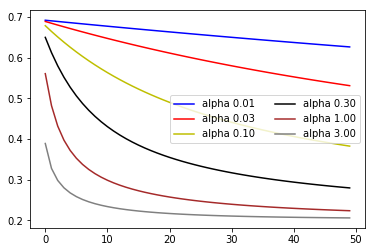

In [18]:
    # To plot the J(theta) using different alphas
    fig, ax = plt.subplots()
    iterations = range(num_iters)

    print('Running gradient descent ...\n')
    for alpha, color in zip(alphas, colors):
        theta = np.zeros([n + 1]) # reset the theta to the current alpha

        theta, J_history = logisticGradientDescent(X, y, theta, alpha, num_iters)
        # print('alpha ', alpha, ' found theta ', theta)
        plt.plot(iterations, J_history, color=color, label='alpha %.2f' % alpha)

    plt.legend(loc='best', ncol=2)

In [19]:
# Display gradient descent's result
print('Theta computed from gradient descent:');
# Expected ~= [ 1.426919, 3.391232, 3.142802]
print(theta);

Theta computed from gradient descent:
[1.42691898 3.39123191 3.14280162]


In [20]:
predict = [45, 85]
# normalize and add the x_0 = 1
predict_norm = np.column_stack((np.ones(1), [((predict - mu) / sigma)]))
prob = hypothesis(predict_norm, theta)
print('For a student with scores 45 and 85, we predict an admission probability of', prob)
print('Expected value: 0.732');

# Compute accuracy on our training set
p = hypothesis(X, theta)

print('Train Accuracy: ', ((p >= 0.5) == y).sum().mean())
print('Expected accuracy (approx): 89.0\n')

For a student with scores 45 and 85, we predict an admission probability of [0.73200061]
Expected value: 0.732
Train Accuracy:  89.0
Expected accuracy (approx): 89.0



## ==================== Part 3: Plotting Boundary Decision ====================

In [21]:
# Calculate the boundary decision
score1_min = x[:,0].min()
score1_max = x[:,0].max()
score2_min = x[:,1].min()
score2_max = x[:,1].max()

xgrid = np.arange(score1_min, score1_max, (score1_max - score1_min) / 100)
ygrid = np.arange(score2_min, score2_max, (score2_max - score2_min) / 100)

X,Y = np.meshgrid(xgrid, ygrid) # grid of points
gridPoints = np.c_[X.ravel(), Y.ravel()]

predictions = np.zeros(len(gridPoints))
for i in range(len(gridPoints)):
    point = gridPoints[i]
    predict_norm = np.column_stack((np.ones(1), [((point - mu) / sigma)]))
    prob = hypothesis(predict_norm, theta)
    predictions[i] = 1 if prob >= 0.5 else 0
    
predictions = predictions.reshape(X.shape)

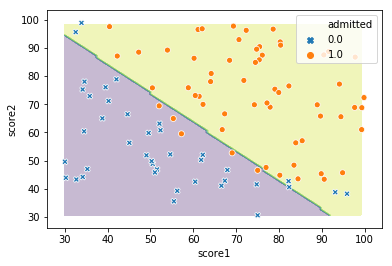

In [22]:
fig, ax = plt.subplots()
# setup plot for decision boundary (0 = Refused, 1 = Admitted)
plt.contourf(X, Y, predictions, alpha=0.3)
sns.scatterplot('score1', 'score2', hue='admitted', style='admitted', style_order=[1,0], data=data)
plt.legend()
# plt.show()